## Deep Learning notebook (Pytorch models)

In this notebook, we will make use of the cleaned data from the previous stage to build four different deep learning models (**Feed-forward NN**, **Simple bi-directional RNN**, **CNN** and **Bi-directional GRU**) using `Pytorch`. A more detailed outline of this notebook:
- Data preprocessing: perform tokenization, numerical encoding, padding/truncating the text.
- FastText word embeddings: use the numerical encoding of the data to construct word embeddings.
- Helper functions: build the necessary functions for training and evaluation.
- Feed-forward model/Simple RNN/CNN/GRU: Build and train each model accordingly.
- Model evaluation: Evaluate the models' training process and classification results.

### Importing packages

In [ ]:
# utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# keras
from tensorflow import keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import set_random_seed

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

set_random_seed(13)

### Data preprocessing

We begin by loading in the cleaned data.

In [5]:
X = np.load('../data/preprocessed_data/feature_vectors_normal.npy', allow_pickle=True)
y = np.load('../data/preprocessed_data/target_vectors_normal.npy', allow_pickle=True)

For the train-test split, we may use the same ratio 90:10 to ensure the model has more data for training. Additionally, it is necessary to construct a validation set for evaluation during training, which help tracking the relative performance of the model.

In [6]:
X_train_split, X_test_split, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=13)
X_test_split, X_val_split, y_test, y_val = train_test_split(X_test_split, y_test, train_size=0.5, random_state=13)

print("Train set size:", X_train_split.shape[0])
print("Test set size", X_test_split.shape[0])
print("Validation set size", X_val_split.shape[0])

Train set size: 1436272
Test set size 79793
Validation set size 79793


Let's vectorize `X` and `y`. Here, we use `keras`'s tokenizer because it allows us to preprocess the data in a simpler and more convenient fashion than Pytorch's `torchtext` or `pytorch-nlp`. 

In [7]:
# Initiate Keras tokenizer and vectorizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_split)

# Transfrom X into vectorized values
X_train_transformed = tokenizer.texts_to_sequences(X_train_split)
X_val_transformed = tokenizer.texts_to_sequences(X_val_split)
X_test_transformed = tokenizer.texts_to_sequences(X_test_split)

# View vocabulary size
print("Vocabulary size: ", len(tokenizer.word_index))

Vocabulary size:  218947


In [8]:
# Initiate the label encoder to convert target data into (0, 1) instead of (0, 4)
label_encoder = LabelEncoder()

# Transform y into numerical values (0, 1)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

We are not yet finished. From the summary, it is quite noticeable that the lengths of the word vectors are largely uneven and deviating. This is why we should always consider padding/truncating during preprocessing. While this is not required for all deep learning model, uneven length in data may give the model a harder time to process batches and slow down the computation process. 

In [9]:
print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text.split()) for text in X]).describe(percentiles=[.25, .5, .75, .9, .975]).apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1595858.00
mean          12.07
std            6.65
min            1.00
25%            7.00
50%           11.00
75%           17.00
90%           22.00
97.5%         25.00
max           52.00
dtype: object

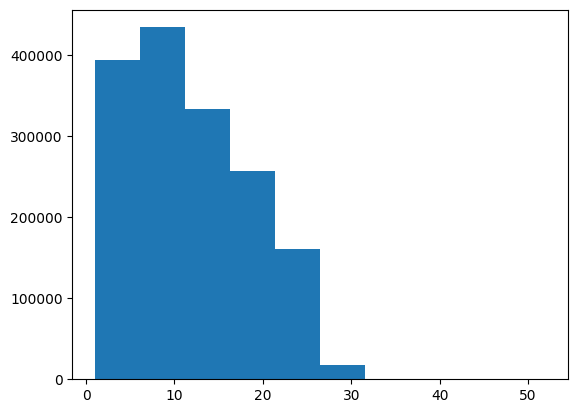

In [10]:
plt.hist([len(text.split()) for text in X])
plt.show()

Let us choose 25 as the default sequence length, which covers most of the data we are dealing with already. Padding and truncating will be performed accordingly.

In [11]:
# Perform padding on X_transformed
X_train_transformed = pad_sequences(X_train_transformed, maxlen=25, padding='post', truncating='post')
X_val_transformed = pad_sequences(X_val_transformed, maxlen=25, padding='post', truncating='post')
X_test_transformed = pad_sequences(X_test_transformed, maxlen=25, padding='post', truncating='post')

print('Statistics summary of vector lengths in X_transformed: ')
pd.Series([len(text) for text in X_train_transformed]).describe().apply("{0:.2f}".format)

Statistics summary of vector lengths in X_transformed: 


count    1436272.00
mean          25.00
std            0.00
min           25.00
25%           25.00
50%           25.00
75%           25.00
max           25.00
dtype: object

Finally, let us load the train-test-validation set into Tensors, and then DataLoader. This step is required if we want to load our data into Pytorch models. Here, we are using a batch size of 128 - not too large, but not too small as well. This ensures that the model learns with a reasonably slow pace to avoid overfitting.

In [12]:
train_set = TensorDataset(torch.tensor(X_train_transformed), torch.tensor(y_train).reshape(-1, 1))
val_set = TensorDataset(torch.tensor(X_val_transformed), torch.tensor(y_val).reshape(-1, 1))
test_set = TensorDataset(torch.tensor(X_test_transformed), torch.tensor(y_test).reshape(-1, 1))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=128)

### FastText word embeddings

Let us load the FastText word embeddings in using `gensim`. 

In [ ]:
# gensim FastText word embeddings
from gensim.models import KeyedVectors
kv_model = KeyedVectors.load_word2vec_format('../utils/crawl-300d-2M.vec')

Now, we may continue building the embedding word vectors from our built vocabulary. The idea is to loop through each item in our vocabulary to see for each word if the word embeddings model has the embedding vectors for it. If yes, we may load it into our embeddings matrix; otherwise, we leave it as empty (fill with zeros).

In [13]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDINGS_DIM = 300

In [14]:
# Initiate an empty matrix as a embeddings container
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDINGS_DIM))

# Loading GloVe weights into our embedding matrix
for word, index in tokenizer.word_index.items():
  if word in kv_model:
    embedding_matrix[index] = kv_model[word].copy()

embedding_matrix = torch.FloatTensor(embedding_matrix)

Let us look at the shape of the embedding matrix for dimensionality check. It should be (vocabulary size, embeddings dimension).

In [15]:
embedding_matrix.shape

torch.Size([218948, 300])

### Helper functions

Before beginning, let us switch the device to GPU, where we can obtain much computational power.

In [16]:
# Switch to use GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


To obtain reproducible results, let's set a seed for Pytorch. 

In [17]:
torch.manual_seed(13)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(13)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Here, we build a series of functions needed for the training process using Pytorch. This is quite default so there is no need to understand everything, as the training process will be elaborated later. 

In [18]:
class EarlyStopper:
  """
  Early stopping function
  """
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

In [19]:
def evaluate(model, data_loader, data_set, criterion):
  """
  Function to evaluate the model based on the validation set during training.
  """
  model.eval()
  total_correct = 0
  total_loss = 0
  with torch.no_grad():
    for input, target in val_loader:
      if torch.cuda.is_available():
        input, target = input.to(device), target.to(device)

      output = model(input)
      loss = criterion(output, target.float())
      total_loss += loss
      total_correct += ((output>0.5)==target).sum()

  return (total_loss/len(data_loader), total_correct/len(data_set))

In [20]:
def train(model, train_loader, val_loader, train_set, val_set, optimizer, criterion, early_stopper, num_epochs=50):
  """
  Function to train the model. Additionally, return the training/validation loss and accuracies.
  """
  train_loss_arr = []
  train_accu_arr = []
  val_loss_arr = []
  val_accu_arr = []
  
  for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_correct = 0

    model.train()
    for input, target in train_loader:
      if torch.cuda.is_available():
        input, target = input.to(device), target.to(device)

      output = model(input)

      loss = criterion(output, target.float())
      total_train_loss += loss.item()
      total_train_correct += ((output > 0.5)==target).sum()
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    val_loss, val_accuracy = evaluate(model, val_loader, val_set, criterion)
    train_loss = total_train_loss/len(train_loader)
    train_accuracy = total_train_correct/len(train_set)

    train_loss_arr.append(train_loss)
    train_accu_arr.append(train_accuracy.item())
    val_loss_arr.append(val_loss.item())
    val_accu_arr.append(val_accuracy.item())

    print(f'Epoch {epoch+1}/{num_epochs} | ' +
          f'Training loss: {train_loss:.4f}, Training accuracy: {train_accuracy:.4f}, ' + 
          f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}')
    
    if early_stopper.early_stop(val_loss.item()):             
      break

  return (train_loss_arr, train_accu_arr, val_loss_arr, val_accu_arr)

In [21]:
def report(model, data_loader, train_stats):
  """
  Function to evaluate the model during and after the training process.
  """
  model.eval()
  y_pred = []
  y_test = []

  for input, target in data_loader:
    if torch.cuda.is_available():
      input, target = input.to(device), target.to(device)
    output = model(input)
    y_pred += (output > 0.5).cpu().tolist()
    y_test += target.cpu().tolist()

  print("Training performance:")
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  ax[0].plot(train_stats[0])
  ax[0].plot(train_stats[2])
  ax[1].plot(train_stats[1])
  ax[1].plot(train_stats[3])
  plt.show()

  print("Classification report on test set:")
  print(classification_report(y_pred, y_test))

### Feed foward model:

We may begin my building the most basic model of all neural network: Feed-forward model. Its architecture is actually quite similar to multi-layer perceptrons, but with non-linearity nodes:

!["Feed-forward architecture, Speech and Language Processing, J. Daniel"](../resources/ff-architect.png)

For each hidden layer, we perform linear transformation on each of the input vector of features $x = [x_1, x_2,...,x_n]$ (each sentence in our case), then apply an *activation function* $\sigma$ to add in some non-linearity for the results (usually it's ReLU), therefore adding more complexity for the model to recognize more sotisphicated patterns in the data. To describe this mathematically:

$$
\begin{align}
y' = Wx + b \\
h = \text{ReLU} (y')
\end{align}
$$

We can perform this many times we want, and for each time, we are essentially adding new layers to our model. Finally, we can add the same linear layer to get the output, but with a slightly different approach:

$$
z = Uh \\
y = \text{Sigmoid}(z)  
$$

This time, we may simplify the transformation by multiplying with only the weight bias, then apply $\text{sigmoid}$ to obtain results in range [0, 1], which is needed for our binary classification problem. If one is working with multi-class classification however, the usual activation function for the last layer is $\text{softmax}$.

How does the model train then? Let's not get too deep into the math here, because it deviates from our problem. Intuitively, we want to train in epochs, where for each epoch, the training process will take into account the whole training set. After a series of transformation of the inputs using random weights $W$, $b$ and $U$, we obtain the output $y_{pred}$. The model then compute the loss using $y_{true}$ and then performs *backward-differentiation* (essentially computing gradients) to record how each immediate transformation affect the final loss. Then we can **update** the (initially) random weights $W$, $b$ and $U$ accordingly, similarly to gradient descent. With many epochs, the weights will get updated more and more to model the training data closer. 

Given that our training data is quite large, it would be naive to put the whole data into one forward/backward pass for an epoch, because it would not be able to learn effectively. Because of this, we need to divide the data into smaller batches earlier. Now, each batch will be considered as the new "training data" and the training process goes on as described for each of the batches until we go through all of them.

Let us now implement our thoughts into Pytorch. We may begin by initializing the required elements of our deep learning model: 

In [22]:
# The output of the model [0, 1]
OUTPUT_SIZE = 1
# The size of the hidden layers (how many neural nodes to use)
HIDDEN_SIZE = 512
# Batch size 
BATCH_SIZE = 128
# Number of epochs
NUM_EPOCHS = 50

The model we are building will have 2 hidden layers, which will have 512 and 256 hidden nodes respectively, and 1 output layers. Additionally, we also employ 1 embedding layers to transform our input sequence into word embeddings. 

Given that the word embeddings will create a vector for each token, we need to find a way to aggregate the vectors into one single vector (pooling), representing the whole sentence. There are many different approach to this (taking the mean of the vectors, etc.), but for this, we would like to sum them up, because our data might have many OOVs, which cause the word embeddings to be all zeros. Because of this, we do not want the OOVs to affect the representation of the full sentence from taking the mean. 

We are also interested in applying *drop-out* to regularize the model, ensuring that there is a lower chance of overfitting. As its name, the main idea of this is to randomly drop out a percentage of all connections between layers, therefore ensuring that the model only learns to generalize features but not to replicate them.

In [23]:
class FeedForward(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, dropout=0.5):
    super(FeedForward, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
    self.linear_stack = nn.Sequential(
      nn.Linear(in_features=embedding_dim, out_features=hidden_size),
      nn.ReLU(),
      nn.Dropout(p=dropout),
      nn.Linear(in_features=hidden_size, out_features=hidden_size//2),
      nn.ReLU(),
      nn.Linear(in_features=hidden_size//2, out_features=output_size, bias=False),
      nn.Sigmoid()
    ) 

  def forward(self, input):
    emb = self.embedding(input)
    emb = torch.sum(emb, dim=1)
    out = self.linear_stack(emb)
    return out

ff_model = FeedForward(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, 0.5).to(device)
print(ff_model)

FeedForward(
  (embedding): Embedding(218948, 300)
  (linear_stack): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=1, bias=False)
    (6): Sigmoid()
  )
)


Here, we use the binary cross-entropy loss (BCELoss), which is default to binary classification problem. An optimizer is also defined with a learning rate and a weight decay. The weight decay acts as a regularizer and penalize big weights $W$, which help us avoid overfitting, a very common problem when using deep learning. *Early stopping* is also use to stop the training process after a few epochs as soon as we see the validation loss starting to rise too much (overfitting).

In [24]:
ff_criterion = nn.BCELoss()
ff_optimizer = torch.optim.Adam(ff_model.parameters(), lr=1e-4, weight_decay=1e-7)
ff_early_stopper = EarlyStopper(patience=3, min_delta=3e-4)

ff_train_stats = train(ff_model, train_loader, val_loader, train_set, val_set, ff_optimizer, ff_criterion, ff_early_stopper, NUM_EPOCHS)

Epoch 1/50 | Training loss: 0.4720, Training accuracy: 0.7757, Validation loss: 0.4429, Validation accuracy: 0.7938
Epoch 2/50 | Training loss: 0.4446, Training accuracy: 0.7908, Validation loss: 0.4340, Validation accuracy: 0.7987
Epoch 3/50 | Training loss: 0.4355, Training accuracy: 0.7960, Validation loss: 0.4277, Validation accuracy: 0.8021
Epoch 4/50 | Training loss: 0.4296, Training accuracy: 0.7995, Validation loss: 0.4236, Validation accuracy: 0.8051
Epoch 5/50 | Training loss: 0.4255, Training accuracy: 0.8016, Validation loss: 0.4209, Validation accuracy: 0.8059
Epoch 6/50 | Training loss: 0.4221, Training accuracy: 0.8035, Validation loss: 0.4199, Validation accuracy: 0.8064
Epoch 7/50 | Training loss: 0.4195, Training accuracy: 0.8049, Validation loss: 0.4194, Validation accuracy: 0.8076
Epoch 8/50 | Training loss: 0.4173, Training accuracy: 0.8060, Validation loss: 0.4171, Validation accuracy: 0.8081
Epoch 9/50 | Training loss: 0.4150, Training accuracy: 0.8074, Validatio

The feed-forward model is very simple and quick to train, yet it performs quite good on our validation data, based on what we observe from the training log. Nonetheless, let us inspect the performance of the model further in the final section, where we may additionally use the same statistics to compare different models to each other.

### Simple recurrent neural network (RNN):

RNN has a very interesting architecture. Like its name, it utilizes a *recurrent structure* to "memorize" temporarily the previous tokens, therefore take into account a very important factor such as positions of the token and represent the sentence as a whole better. The overall structure of the network resembles to that of the feed-forward model, but with a very special structure for each node within the hidden layer:

![](../resources/rnn-architect.png)

For each node, the model once again takes into account each feature vector $x$. However, instead of processing them all at once, we would process them on different *timesteps*. For the first time step, we perform linear operation then apply activation function on the very first feature (word) $x_1$ to obtain a a hidden output $h_1$. The hidden output of the first timestep will be considered into the next time step, and so on. To describe this mathematically:

$$
y' = U h_{t-1} + W x_t\\
h_t = \text{ReLU}(y')
$$

Here, the model computes immediate output $y_i$ based on the hidden output at each timestep, representing the part from word 1 to $i$ of the sentence so far:

$$
y_t = \text{Sigmoid}(V h_t)
$$

Given the nature of our task, we are only interested in the representation of the whole sentence, which is the immediate output $y$ at the last timestep. 

We may also *stack* RNN layers onto each other to add more complexity to the modelling, by using the immediate output at each timestep to be the input for the same timestep of the next layer:

![](../stacked-rnn-architect.png)

Here, in order to model more accurately the positional factor of sentences in our data. We may also use *bidirectional modelling* in the RNN model. Instead of just processing the text sequence from left to right, we also have an additional layer that processed independently the text in *reverse*, from right to left. To combine the results, we simply concatnate the two hidden vectors of two layers together for each timestep:

$$
h_{stacked_t} = [h_{forward_t}, h_{backward_t}] \\
y_t = \text{Sigmoid}(V h_{stacked_t})
$$

After obtaining the last output of the hidden layer, we may proceed to apply it through a final output layer to condense the model into one final output, similarly to the previous model.

During training, the process is the same: the loss is computed for the final output, then gradients are computed during backward pass to update the weights using gradient descent. 

Now, we are ready to build our Bidirectional RNN model. Let's initialize the required parameters of the model. 

In [25]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 3
BATCH_SIZE = 128
NUM_EPOCHS = 30

One can experiment with different settings and parameters to be more suitable with different machine powers and preferences. Here, we would like to use a 3-layered bi-directional RNN structure with 1 additional output layer. Additionally, the model has 256 hidden nodes for each layer. Again, we also employ an emebedding layer to encode the input before training.  

In [26]:
class BiRNN(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super(BiRNN, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.rnn = nn.RNN(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        nonlinearity='relu',
        batch_first=True,
        dropout=dropout,
        bidirectional=True,
      )
    self.out_layer = nn.Sequential(
      nn.Dropout(p=dropout),
      nn.Linear(in_features=hidden_size*2, out_features=output_size, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, hidden = self.rnn(emb)
    out = self.out_layer(out[:,-1,:])
    return out
  
rnn_model = BiRNN(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(rnn_model)
    

BiRNN(
  (embedding): Embedding(218948, 300)
  (rnn): RNN(300, 256, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


Once again, BCE loss is used, along with Adam optimizer and an early stopper object. This time however, the weight decay rate has been increased to regularize better due to the high complexity of the model (therefore more prone to overfitting). 

In [27]:
rnn_criterion = nn.BCELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
rnn_early_stopper = EarlyStopper(patience=3, min_delta=3e-4)

rnn_train_stats = train(rnn_model, train_loader, val_loader, train_set, val_set, rnn_optimizer, rnn_criterion, rnn_early_stopper, NUM_EPOCHS)

Epoch 1/30 | Training loss: 0.4395, Training accuracy: 0.7925, Validation loss: 0.3999, Validation accuracy: 0.8202
Epoch 2/30 | Training loss: 0.3925, Training accuracy: 0.8239, Validation loss: 0.3860, Validation accuracy: 0.8278
Epoch 3/30 | Training loss: 0.3780, Training accuracy: 0.8313, Validation loss: 0.3766, Validation accuracy: 0.8317
Epoch 4/30 | Training loss: 0.3680, Training accuracy: 0.8367, Validation loss: 0.3750, Validation accuracy: 0.8340
Epoch 5/30 | Training loss: 0.3605, Training accuracy: 0.8407, Validation loss: 0.3720, Validation accuracy: 0.8355
Epoch 6/30 | Training loss: 0.3540, Training accuracy: 0.8445, Validation loss: 0.3690, Validation accuracy: 0.8375
Epoch 7/30 | Training loss: 0.3478, Training accuracy: 0.8476, Validation loss: 0.3679, Validation accuracy: 0.8388
Epoch 8/30 | Training loss: 0.3422, Training accuracy: 0.8507, Validation loss: 0.3747, Validation accuracy: 0.8345
Epoch 9/30 | Training loss: 0.3368, Training accuracy: 0.8535, Validatio

### Convolutional neural network (CNN)

CNN has one of the most unique structures in deep learning. While it is quite commonly used in Computer Vision as an approach to deal with image data, it still can be useful in text processing. Instead of using image matrices as inputs, we can utlize our word embedding vectors and have a similar input. Let us take a look at the network's architecture:

![](../resources/cnn-architecture.png)

The main idea of the structure is to apply *filters* (or *kernels*) of different size, where each filter of size $n$ captures the n-gram features of the word embeddings. Note that we can have many filters of the same size to learn the features in a higher depth. From each filter having the same size n, we use a moving window of size n and slide them through the word embeddings and perform element-wise multiplication and sum up the elements to form feature map vectors. We then find the maximum of each of the feature map vectors (max pooling) to create a smaller sample representing multiple n-gram features of the whole sentences.

To clear this up, let us use math notations. We assume that we are interested in using filters of size $a, b, c$ with $k$ number of filters for each of them. The feature mapping can be obtained by:

$$
f'_{a1} = [sum(X_{\text{partitioned}_1} \circ W_{a1}), sum(X_{\text{partitioned}_2} \circ W_{a1}), ..., sum(X_{\text{partitioned}_{n-a+1}} \circ W_{a1})] \\

f_{a1} = \text{ReLU}(f'_{a1}) \\

... \\ 

f'_{ak} = [sum(X_{\text{partitioned}_1} \circ W_{ak}), sum(X_{\text{partitioned}_2} \circ W_{ak}), ..., sum(X_{\text{partitioned}_{n-a+1}} \circ W_{ak})] \\

f_{ak} = \text{ReLU}(f'_{ak})
$$

We may do the same for $b, c$. After the process, we perform max pooling and concatnating of the feature mappings:

$$
f_a = [max(f_{a1}), max(f_{a2}), ..., max(f_{ak})] \\
f_b = [max(f_{b1}), max(f_{b2}), ..., max(f_{bk})] \\ 
f_c = [max(f_{c1}), max(f_{c2}), ..., max(f_{ck})] \\
f_{a+b+c} = [f_a, f_b, f_c]
$$

To obtain the output, we add the final output layer, similarly to the previous models:

$$
y = \text{Sigmoid}(U f_{a+b+c})
$$

With more filters and more size variations, we may be able to capture much complex semantic features of the textual data. Compared to the RNN model previously, rather than trying to represent the whole sentence, CNN learns in-depth into multiple n-gram features of the sentence and attemps to generalized based on this. 

For the model, we will use 3 kernels of size 2, 3, 4 with 256, 128, 128 number of filters, respectively. The other variables should be default:

In [28]:
OUTPUT_SIZE = 1
BATCH_SIZE = 128
NUM_EPOCHS = 30
FILTER_SIZES = [2, 3, 4]
NUM_FILTERS = [256, 128, 128]

We can now define our CNN model as follows:

In [29]:
class CNN(nn.Module):
  def __init__(self, output_size, embedding_dim, filter_sizes, num_filters, dropout=0.5):
    super(CNN, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)

    self.conv_layers = nn.ModuleList([
      nn.Sequential(
        nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters[i], kernel_size=filter_sizes[i]),
        nn.ReLU()
      )
      for i in range(len(num_filters))
    ])

    self.out_layer = nn.Sequential(
      nn.Dropout(p=dropout),
      nn.Linear(in_features=sum(num_filters), out_features=output_size, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    emb = emb.permute(0, 2, 1)
    out = [conv(emb) for conv in self.conv_layers]
    out = [F.max_pool1d(input=feature_vec, kernel_size=feature_vec.shape[2]) for feature_vec in out]
    out = [torch.squeeze(downsampled_feature_vec) for downsampled_feature_vec in out]
    out = torch.cat(out, dim=1)
    out = self.out_layer(out)
    return out
  
cnn_model = CNN(OUTPUT_SIZE, EMBEDDINGS_DIM, FILTER_SIZES, NUM_FILTERS, .5).to(device)
print(cnn_model)
    

CNN(
  (embedding): Embedding(218948, 300)
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(300, 256, kernel_size=(2,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(300, 128, kernel_size=(4,), stride=(1,))
      (1): ReLU()
    )
  )
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


The loss function, optimizer and early stopper settings are the same:

In [30]:
cnn_criterion = nn.BCELoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
cnn_early_stopper = EarlyStopper(patience=3, min_delta=3e-4)

cnn_train_stats = train(cnn_model, train_loader, val_loader, train_set, val_set, cnn_optimizer, cnn_criterion, cnn_early_stopper, NUM_EPOCHS)

Epoch 1/30 | Training loss: 0.4457, Training accuracy: 0.7935, Validation loss: 0.4104, Validation accuracy: 0.8147
Epoch 2/30 | Training loss: 0.4103, Training accuracy: 0.8143, Validation loss: 0.3963, Validation accuracy: 0.8219
Epoch 3/30 | Training loss: 0.3982, Training accuracy: 0.8214, Validation loss: 0.3891, Validation accuracy: 0.8270
Epoch 4/30 | Training loss: 0.3907, Training accuracy: 0.8258, Validation loss: 0.3851, Validation accuracy: 0.8301
Epoch 5/30 | Training loss: 0.3849, Training accuracy: 0.8289, Validation loss: 0.3816, Validation accuracy: 0.8305
Epoch 6/30 | Training loss: 0.3802, Training accuracy: 0.8315, Validation loss: 0.3799, Validation accuracy: 0.8316
Epoch 7/30 | Training loss: 0.3765, Training accuracy: 0.8336, Validation loss: 0.3789, Validation accuracy: 0.8326
Epoch 8/30 | Training loss: 0.3735, Training accuracy: 0.8353, Validation loss: 0.3778, Validation accuracy: 0.8333
Epoch 9/30 | Training loss: 0.3704, Training accuracy: 0.8369, Validatio

### Gated recurrent unit (GRU)

With long sequences length, the simple RNN's performance can be worse because its long-term memory stored in the hidden state is affected by the noise in the data of more recent timestamp. Moreover, RNN only has recurrent connections to store long-term dependencies, which means that the gradients of a parameter may depend on many previous inputs and hidden outputs, causing the gradients to multiply or decay exponentially to zero (vanishing gradient). Because of this, it is common to switch to use the LTSM (long short-term memory) or GRU, its simplier alternative to safe guard this. Both structures utilized "gates" mechanism to decide to close/open for some input to be processed. Nonetheless, given the not-so-long length of text sequences in our data (30), the LTSM, which is much more complex than the GRU, may not be able to excel in performance while causing us large computational costs and time. Because of this, the GRU network is being considered:

![](../resources/gru-architect.jpg)

The update gate is responsible for the short-term memory, where it decides what new information to add. On the other hand, the reset gate is for long-term memory and it determines how much of the past information should be passed along.

$$
r_t = \text{Sigmoid}(U_r x_t + W_r h_{t-1} + b_r) \\ 
u_t = \text{Sigmoid}(U_u x_t + W_u h_{t-1} + b_u) \\
$$ 

Now, we can use the reset gate to decide how much long-term information to forget:

$$
\hat{h}_t = \text{tanh}(\hat{U} x_t + \hat{W} (r_t \circ h_{t-1}))
$$

Then, we can obtain the hidden output by updating new short-term information:

$$
h_t = u_t \circ h_{t-1} + (1-u_t) \circ \hat{h}_t
$$

Finally, the output can be obtained similarly to that of RNN:

$$
y_t = \text{Sigmoid}(V h_t)
$$

Now, we may start to build the model using the default settings.

In [31]:
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BATCH_SIZE = 128
NUM_EPOCHS = 30

In [32]:
class BiGRU(nn.Module):
  def __init__(self, output_size, embedding_dim, hidden_size, num_layers, dropout=0.5):
    super(BiGRU, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
    self.rnn = nn.GRU(
        input_size=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout,
        bidirectional=True,
      )
    self.out_layer = nn.Sequential(
      nn.Dropout(p=dropout),
      nn.Linear(in_features=hidden_size*2, out_features=output_size, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    emb = self.embedding(input)
    out, hidden = self.rnn(emb)
    out = self.out_layer(out[:,-1,:])
    return out
  
gru_model = BiGRU(OUTPUT_SIZE, EMBEDDINGS_DIM, HIDDEN_SIZE, NUM_LAYERS, 0.5).to(device)
print(gru_model)
    

BiGRU(
  (embedding): Embedding(218948, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (out_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=1, bias=False)
    (2): Sigmoid()
  )
)


In [33]:
gru_criterion = nn.BCELoss()
gru_optimizer = torch.optim.RMSprop(gru_model.parameters(), lr=1e-4, weight_decay=1e-5)
gru_early_stopper = EarlyStopper(patience=3, min_delta=3e-4)

gru_train_stats = train(gru_model, train_loader, val_loader, train_set, val_set, gru_optimizer, gru_criterion, gru_early_stopper, NUM_EPOCHS)

Epoch 1/30 | Training loss: 0.4459, Training accuracy: 0.7906, Validation loss: 0.4159, Validation accuracy: 0.8105
Epoch 2/30 | Training loss: 0.4069, Training accuracy: 0.8144, Validation loss: 0.3972, Validation accuracy: 0.8193
Epoch 3/30 | Training loss: 0.3936, Training accuracy: 0.8219, Validation loss: 0.3883, Validation accuracy: 0.8242
Epoch 4/30 | Training loss: 0.3849, Training accuracy: 0.8268, Validation loss: 0.3843, Validation accuracy: 0.8277
Epoch 5/30 | Training loss: 0.3780, Training accuracy: 0.8303, Validation loss: 0.3784, Validation accuracy: 0.8300
Epoch 6/30 | Training loss: 0.3726, Training accuracy: 0.8335, Validation loss: 0.3742, Validation accuracy: 0.8312
Epoch 7/30 | Training loss: 0.3677, Training accuracy: 0.8359, Validation loss: 0.3707, Validation accuracy: 0.8342
Epoch 8/30 | Training loss: 0.3632, Training accuracy: 0.8382, Validation loss: 0.3704, Validation accuracy: 0.8347
Epoch 9/30 | Training loss: 0.3592, Training accuracy: 0.8404, Validatio

### Model evaluation

In [34]:
def report(model, data_loader, train_stats):
  """
  Function to evaluate the model during and after the training process.
  """
  model.eval()
  y_pred = []
  y_test = []

  for input, target in data_loader:
    if torch.cuda.is_available():
      input, target = input.to(device), target.to(device)
    output = model(input)
    y_pred += (output > 0.5).cpu().tolist()
    y_test += target.cpu().tolist()

  print("Training performance:")
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(train_stats[0], label='Training set')
  ax[0].plot(train_stats[2], label='Validation set')
  ax[0].set_xlabel('Epoch')
  ax[0].title.set_text('Loss')
  ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.f'))
  ax[1].plot(train_stats[1], label='Training set')
  ax[1].plot(train_stats[3], label='Validation set')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(loc="lower right")
  ax[1].title.set_text('Accuracy')
  ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.f'))
  plt.show()
  
  print(f"Training loss: {round(train_stats[0][-1], 3)} | Training accuracy: {round(train_stats[1][-1], 3)}")
  print(f"Validation loss: {round(train_stats[2][-1], 3)} | Validation accuracy: {round(train_stats[3][-1], 3)}\n")

  print("Classification report on test set:")
  print(classification_report(y_pred, y_test, digits=4))

We may use the `report` function built previously to visualize the training performance, along with the classification report on the test data.

Training performance:


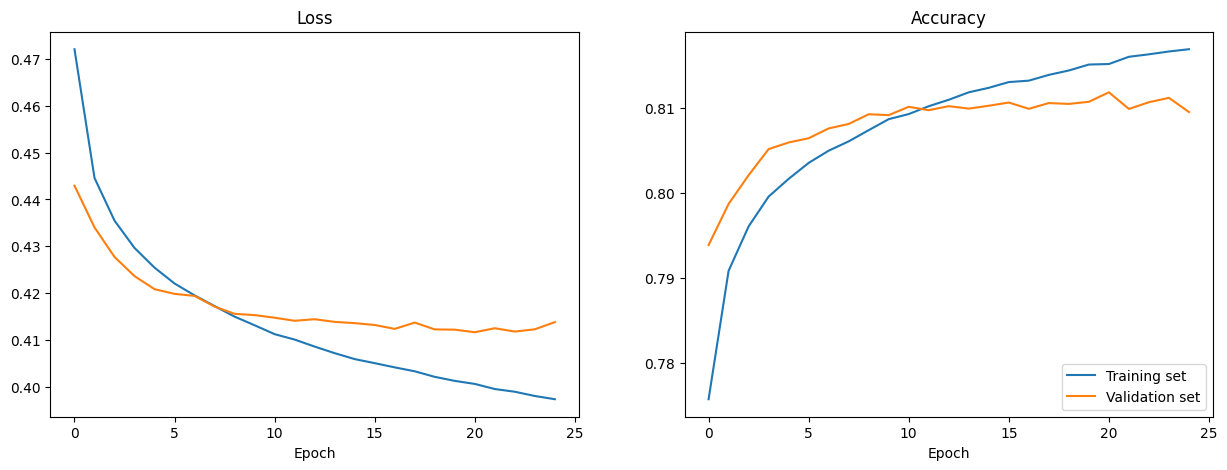

Training loss: 0.397 | Training accuracy: 0.817
Validation loss: 0.414 | Validation accuracy: 0.809

Classification report on test set:
              precision    recall  f1-score   support

       False     0.7961    0.8161    0.8060     38959
        True     0.8202    0.8006    0.8103     40834

    accuracy                         0.8081     79793
   macro avg     0.8082    0.8083    0.8081     79793
weighted avg     0.8084    0.8081    0.8082     79793



In [35]:
report(ff_model, test_loader, ff_train_stats)

Training performance:


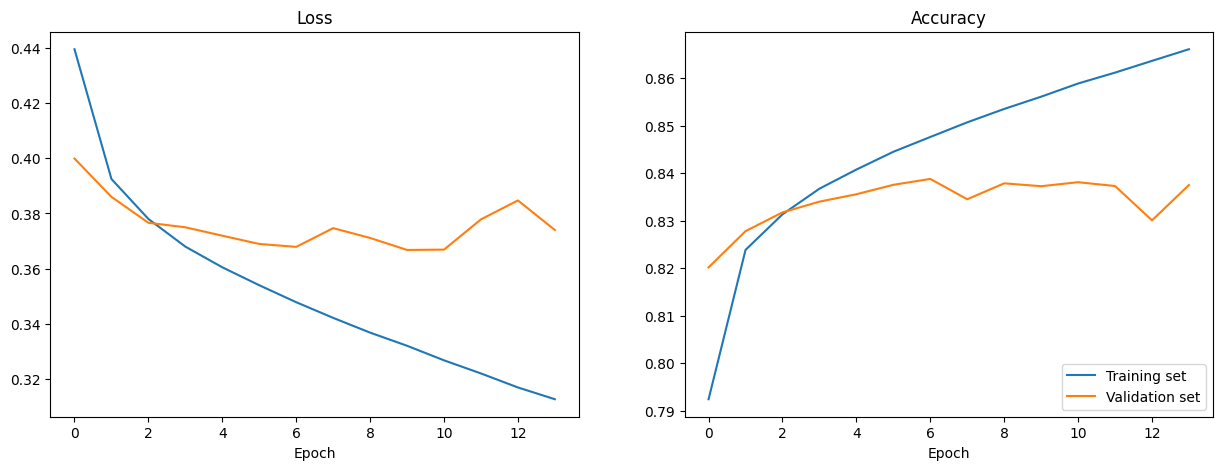

Training loss: 0.313 | Training accuracy: 0.866
Validation loss: 0.374 | Validation accuracy: 0.837

Classification report on test set:
              precision    recall  f1-score   support

       False     0.8342    0.8392    0.8367     39700
        True     0.8398    0.8348    0.8373     40093

    accuracy                         0.8370     79793
   macro avg     0.8370    0.8370    0.8370     79793
weighted avg     0.8370    0.8370    0.8370     79793



In [36]:
report(rnn_model, test_loader, rnn_train_stats)

Training performance:


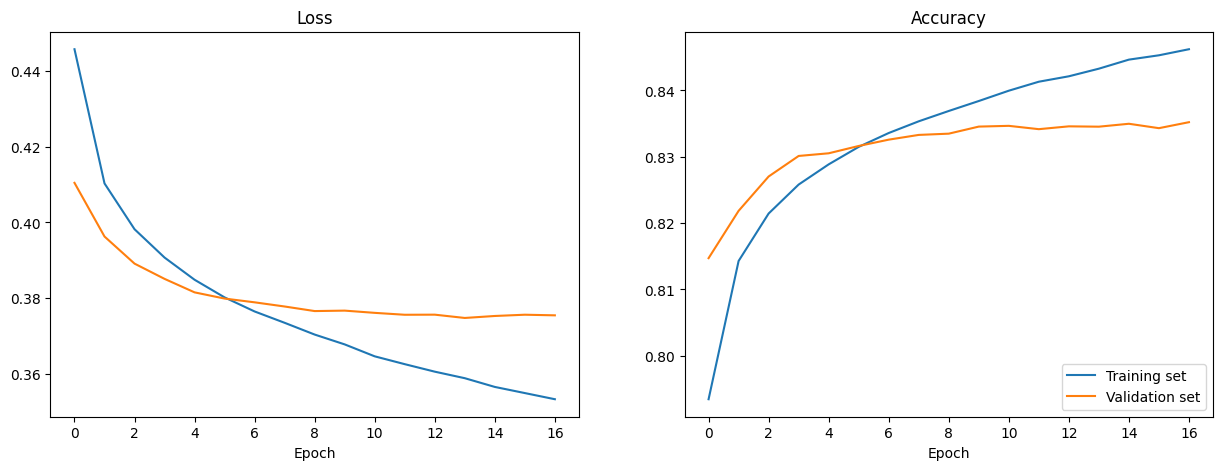

Training loss: 0.353 | Training accuracy: 0.846
Validation loss: 0.376 | Validation accuracy: 0.835

Classification report on test set:
              precision    recall  f1-score   support

       False     0.8358    0.8312    0.8335     40162
        True     0.8299    0.8345    0.8322     39631

    accuracy                         0.8328     79793
   macro avg     0.8328    0.8329    0.8328     79793
weighted avg     0.8329    0.8328    0.8328     79793



In [37]:
report(cnn_model, test_loader, cnn_train_stats)

Training performance:


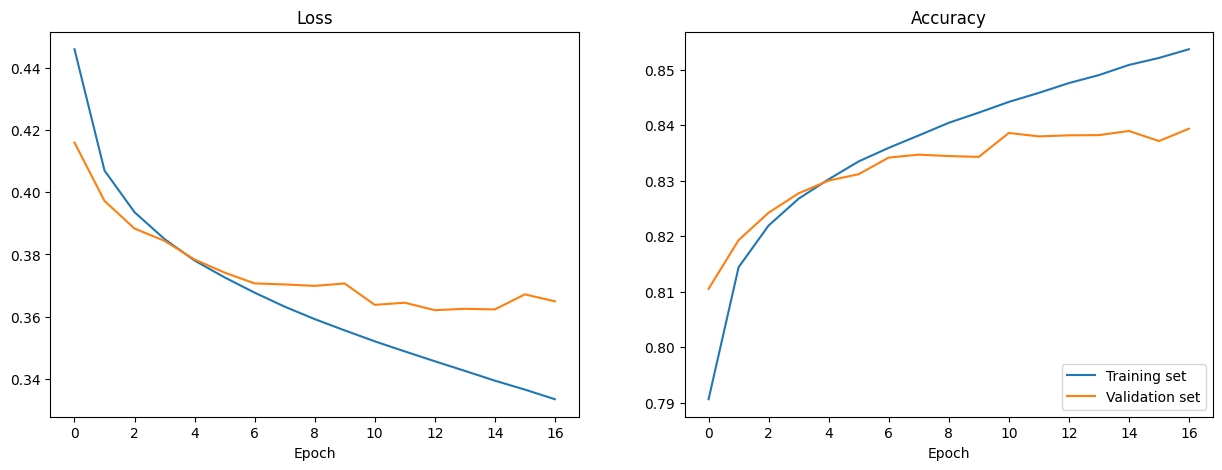

Training loss: 0.333 | Training accuracy: 0.854
Validation loss: 0.365 | Validation accuracy: 0.839

Classification report on test set:
              precision    recall  f1-score   support

       False     0.8656    0.8220    0.8432     42060
        True     0.8121    0.8578    0.8343     37733

    accuracy                         0.8389     79793
   macro avg     0.8389    0.8399    0.8388     79793
weighted avg     0.8403    0.8389    0.8390     79793



In [38]:
report(gru_model, test_loader, gru_train_stats)

**Summary**
- Feed-forward network: The model takes the most epochs to learn, which make sense since a feed-forward network cannot model higher level features in the text as quickly as other complex models. The training process nonetheless is quite stable with the training loss and accuracy progress smoothly. At around the 17th epoch, we can start to see more notable fluctuations from the validation data, implying that the model is starting to overfit. 

  The final accuracy of FFN is only around 81%, which is as good as the simpler Logistic Regression model. In addition, the model has good precision/recall/f1 in general. It is slightly better at catching negative sentiment, but not identifying them. On the other hand, while it is slightly worse at catching positive sentiment, it is much better at separating them with negative sentiment. 

- Bi-directional RNN: The model takes the least epochs to train. After only around 6 epochs, both losses decreases quickly, while the validation loss is able to get to around 0.37 and then converges. Although the model has overfitted very quickly, it has the lowest validation loss and highest accuracy. Given that the sequences length are quite short (30 tokens), and given the complexity of the model, it may have discovered some important feature and it is understandable why the model starts to learn very quickly and overfit early on.

  Although the model suffers from overfitting, the final accuracy of RNN model reaches 84%, which is a solid improvement compared to FFN. Overall, the model has good precision/recall/f1 in general. This time, however, the model exhibits the opposite pattern to the previous FNN model, where it is slightly better at catching negative sentiment and identifying positive ones. 

- CNN: Although CNN model learns slower than RNN, it and has smooth convergence and far less signs of overfitting. It is most notable that the model is the fastest to complete training. Perhaps this is because CNN architecture makes it easy for parallelization. Nonetheless, the validation loss converges at a slightly higher loss and lower accuracy than RNN.

  The model also concludes with around 84%, with good precision/recall/F1. It also exhibits the same pattern of precision/recall on the sentiment as the FFN model. 

- Bi-directional GRU: Being the most complex model, GRU takes the longest time to train. However, the model learning curve shape is relatively similar to that of RNN, but with a slower learning rate. Surprisingly, it is also visible that the model has less signs of overfitting. 

  The model also have relatively good accuracy (84%)/precision/recall/F1. It is however most notable that the model performs significantly better at identifying negative sentiment. Possibly, it may have been able to learn a higher-level pattern in the data that the other model fails to capture. 

